# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

# Disclaimer, 
### 1. I ran the model several times since it had to be rerun after restarting jupyter lab, so every explanation and context part can be different than the current topic model, but the topics are provided before every explanation 

### 2. Again, a lot of the code and actual topic modeling functions are taken from the earlier lab notebooks, mostly the week 6 topic modeling lab notebook

### 3. A lot of cells are edited and not run afterwards, because I improved some comments at the end before handing in, but I did not want to run again and change the output

In [2]:
# Q1 (code)
import tomotopy as tp # this library is used for the topic modeling
import little_mallet_wrapper # this library is also for topic modeling functions
import seaborn # this library is used for data visualization
import glob # can be used to find files
from pathlib import Path # to find directories
import pandas as pd # to make dataframes

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [3]:
# Q2 (code)
sanders = pd.read_csv("sanders_tweets.csv")
trump = pd.read_csv("trump_tweets.csv")
tweets = pd.concat([sanders, trump])

In [4]:
tweets

,Username,TweetId,Title,Content
0,SenSanders,1351670845639421952,SenSanders_1351670845639421952,Wealth increase in past 10 months:\n⬆️$173 bil...
1,SenSanders,1351259762722279424,SenSanders_1351259762722279424,Amidst massive income and wealth inequality te...
2,SenSanders,1351242822293319680,SenSanders_1351242822293319680,"“We now have the resources, we now have the sk..."
3,SenSanders,1350885541911400448,SenSanders_1350885541911400448,"After surviving an attempt on his life, Russia..."
4,SenSanders,1349880150041780224,SenSanders_1349880150041780224,President-Elect Biden's COVID rescue plan will...
...,...,...,...,...
23070,@realDonaldTrump,1346912780700577792,@realDonaldTrump_1346912780700577792,I am asking for everyone at the U.S. Capitol ...
23071,@realDonaldTrump,1346928882595885058,@realDonaldTrump_1346928882595885058,https://t.co/Pm2PKV0Fp3
23072,@realDonaldTrump,1347334804052844550,@realDonaldTrump_1347334804052844550,https://t.co/csX07ZVWGe
23073,@realDonaldTrump,1347555316863553542,@realDonaldTrump_1347555316863553542,"The 75,000,000 great American Patriots who vo..."


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [5]:
# Q3 (code)
import nltk
from nltk.corpus import stopwords
import string
import re

nltk.download("stopwords")

stop_words = stopwords.words("english")
# During the topic modeling, there were still words I did not like were in there
extra_words = ["amp", "rt"]

# make a function that preprocesses the text
def text_preprocess(text):
    #makes the text lowercase
    processed_text = text.lower()
    #gets rid of punctuation
    processed_text = "".join(character for character in processed_text if character not in string.punctuation)
    #get rid of numbers
    processed_text = "".join(character for character in processed_text if not character.isdigit())
    #gets rid of stopwords
    processed_text = " ".join(word for word in processed_text.split() if word not in stop_words)
    #gets rid of words in a list i made with extra words I found annoying after I ran the model the first time
    processed_text = " ".join(word for word in processed_text.split() if word not in extra_words) 
    #the code provided
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', processed_text, flags=re.MULTILINE)
    return processed_text

tweets["pre_processed"] = tweets["Content"].apply(text_preprocess)

#creating a list for training_data, original_texts and titles (username + tweet_id)
training_data = tweets["pre_processed"].tolist()
original_texts = tweets["Content"].tolist()
titles = [(Username, TweetId) for Username, TweetId in zip(tweets["Username"], tweets["TweetId"])]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harmb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
tweets

,Username,TweetId,Title,Content,pre_processed
0,SenSanders,1351670845639421952,SenSanders_1351670845639421952,Wealth increase in past 10 months:\n⬆️$173 bil...,wealth increase past months ⬆️ billion elon mu...
1,SenSanders,1351259762722279424,SenSanders_1351259762722279424,Amidst massive income and wealth inequality te...,amidst massive income wealth inequality tens m...
2,SenSanders,1351242822293319680,SenSanders_1351242822293319680,"“We now have the resources, we now have the sk...",“we resources skills techniques get rid povert...
3,SenSanders,1350885541911400448,SenSanders_1350885541911400448,"After surviving an attempt on his life, Russia...",surviving attempt life russian activist alexei...
4,SenSanders,1349880150041780224,SenSanders_1349880150041780224,President-Elect Biden's COVID rescue plan will...,presidentelect bidens covid rescue plan begin ...
...,...,...,...,...,...
23070,@realDonaldTrump,1346912780700577792,@realDonaldTrump_1346912780700577792,I am asking for everyone at the U.S. Capitol ...,asking everyone us capitol remain peaceful vio...
23071,@realDonaldTrump,1346928882595885058,@realDonaldTrump_1346928882595885058,https://t.co/Pm2PKV0Fp3,
23072,@realDonaldTrump,1347334804052844550,@realDonaldTrump_1347334804052844550,https://t.co/csX07ZVWGe,
23073,@realDonaldTrump,1347555316863553542,@realDonaldTrump_1347555316863553542,"The 75,000,000 great American Patriots who vo...",great american patriots voted america first ma...


## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [7]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob

In [26]:
# Q4 (code)


# code taken from notebook week 6
# Number of topics to return
num_topics = 10
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.452543125040453
Iteration: 10	Log-likelihood: -9.115279232781157
Iteration: 20	Log-likelihood: -8.936523565326247
Iteration: 30	Log-likelihood: -8.847330099891739
Iteration: 40	Log-likelihood: -8.799858509710338
Iteration: 50	Log-likelihood: -8.762752808922224
Iteration: 60	Log-likelihood: -8.737990246685095
Iteration: 70	Log-likelihood: -8.715642996303643
Iteration: 80	Log-likelihood: -8.701967329355744
Iteration: 90	Log-likelihood: -8.686104119977589


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [27]:
# Q5a (code)
# Print out top 10 words for each topic


# code taken from notebook week 6
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

great thank vote state big maga total job endorsement strong

✨Topic 1✨

people would get wall many us much money country states

✨Topic 2✨

must people border country democrats us congress want senate court

✨Topic 3✨

president trump american jobs us change climate energy americans new

✨Topic 4✨

health care people tax workers americans must need million pay

✨Topic 5✨

democrats president impeachment house witch collusion trump hunt nothing russia

✨Topic 6✨

great us china trade states deal good united many big

✨Topic 7✨

great today thank whitehouse president honor day america national country

✨Topic 8✨

trump fbi new hillary president book campaign obama clinton story

✨Topic 9✨

news fake media biden joe election never people trump even



## Q5b (words)
### Describe what each topic is about. What ideas, values, or situations do these keywords refer to?
#### All topics are interpreted from the model when I trained it on 10 topics


#### Topic 0: great thank vote state big maga total job endorsement strong

Topic 0 is likely consisting of tweets that are thanking people. This could be thanking for an endorsement, or thanking for a vote. This is implied by the words 'great', 'thank', 'job' (great job?). The word vote and state could also imply that there are tweets in this topic that specifically thank a state for a vote. The presence of the word 'maga' implies that mostly trump tweets this, since his slogan is 'Make America Great Again', often abbreviated as 'maga'.


#### Topic 1: people would get wall many us much money country states

Topic 1 is more opaque. There is talk about people, country, states, 'us' (which could refer to 'us' as a people or the United States') etc. Also included are verbs like 'would' and 'get'. What is an interesting clue however to what the topic could be is the inclusion of 'money' and 'wall'. Money is obvious, but it is probably liked to 'wall' from 'wall street'. On the other hand, it could also mean the border wall between Mexico and the United states. Intersting because it could also be both, since we have sanders tweets and Trump tweets. Trump often talks about money for the border 'wall' (#BuildThatWall), but sanders often talks about money and 'wall street'. 


#### Topic 2: must people border country democrats us congress want senate court

Topic 2 is most likely more specifically talking about immigration. During, after and before Trump's presidency, one of his major focus was on immigration from Mexico into the United States. The word 'border' heavily implies one of the most used popular words he uses. This could also imply the context that the border and immmigration is being talked about. Words like 'democrats', 'congres', 'senate', 'court', means that the tweets could be about how politics is dealing with immigration, and specifically maybe his 'build the wall' plan.

#### Topic 3: president trump american jobs us change climate energy americans new

Topic 3 could be about many different things. Since it features 'President' and 'Trump', it is most likely from tweets of Bernie Sanders talking about Trump. The most striking words here are the words 'climate', 'change', and 'energy', implying that the tweets are about climate change and green energy probably. The words 'jobs', 'americans', 'american' and 'new', could talk about the jobs that changing to a green economy could provide and create, or in a negative sense about the jobs being lost because of climate change. 

#### Topic 4: health care people tax workers americans must need million pay

Topic 4 is probably about 'health care' and 'taxes'. This could be in line with one of Sanders' most important rhetoric and standpoints, that 'millions' of 'americans', 'workers' and 'people' dont have adequate 'health' 'care', and that richer americans 'must' to pay more 'tax' to make health care free

#### Topic 5: democrats president impeachment house witch collusion trump hunt nothing russia

Topic 5 is pretty clear if you get the context. There has been an 'impeachement' process, started by the 'democats' of donald trump, because of his alleged 'collusion' with 'Russia'. He himself has called this a 'witch hunt'. Topic 5 is most likely about the impeachment process. 

#### Topic 6: great us china trade states deal good united many big

Topic 6 is probably about trade with China. One of the policy and rhetoric points of Donald Trump was his trade deals changes with China, which should be more in america's favor. Words like 'great' and 'good' and 'big' imply positive tihngs about the trade with china. 

#### Topic 7: great today thank whitehouse president honor day america national country

Topic 7 is most likely tweets that contain messages about thanks, and praise about america or the white house or president. It is most likely a broader genre of tweets that thank voters and praise america, which is in line with Trump's messaging. 

#### Topic 8: trump fbi new hillary president book campaign obama clinton story

Topic 8 is most likely about Trump's alleging Clinton's laptop containing classified documents. This is implied by the word 'fbi', since the FBI did a research on it. Also, this topic is about a 'book' and a 'story', and Clinton released a book around 2017 after losing the election. It is probable that topic 8 is generally about things that relate to Hillary clinton.

#### Topic 9: news fake media biden joe election never people trump even

Topic 9 is about 'fake news', 'media', 'joe bide' and 'elections'. This is proabably a genre or topic of tweets from Donald Trump talking about the fake media, or the fake elections. Maybe even as far as the stolen elections in 2020. 

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [41]:
# Retraining the Topic Model for coherence

# code taken from notebook week 6

# Number of topics to return
num_topics = 18
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.613557767101248
Iteration: 10	Log-likelihood: -9.178577696088631
Iteration: 20	Log-likelihood: -8.995437864439952
Iteration: 30	Log-likelihood: -8.904735656122837
Iteration: 40	Log-likelihood: -8.844676818249129
Iteration: 50	Log-likelihood: -8.801317485741915
Iteration: 60	Log-likelihood: -8.765181196901525
Iteration: 70	Log-likelihood: -8.73419084942085
Iteration: 80	Log-likelihood: -8.708882031051465
Iteration: 90	Log-likelihood: -8.68772309557354


In [42]:
# There are different metrics for coherence, we choose `c_v`

# code taken from notebook week 6
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5902400582200952 
Per Topic: [0.7434852898120881, 0.6349730551242828, 0.5057492643594742, 0.5580424338579177, 0.5423496067523956, 0.5443357408046723, 0.5917375952005386, 0.6090128034353256, 0.6951353192329407, 0.5093141406774521, 0.6031518816947937, 0.5704672992229461, 0.4872879058122635, 0.7289048939943313, 0.6282856658101081, 0.5017953306436539, 0.518544751405716, 0.6517480701208115]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

# Q6 (words)

### First time topic modeling

#### Number of topics: 10

#### Coherence score: 

Average: 0.5682341580837965 

Per Topic: [0.6462190479040146, 0.4755454480648041, 0.4777359664440155, 0.4576973974704742, 0.6877986043691635, 0.6617714881896972, 0.5507295191287994, 0.5244878068566322, 0.6239095568656922, 0.576446745544672]

### Second time

#### Number of topics: 13

#### Coherence scores:

Average: 0.57810345229048 

Per Topic: [0.4906334258615971, 0.6643320202827454, 0.7614393055438995, 0.5467736423015594, 0.634855180978775, 0.48275091499090195, 0.5751086622476578, 0.5767696529626847, 0.5534475892782211, 0.6138686537742615, 0.5556148916482926, 0.45490805357694625, 0.6048428863286972]

### Third time

#### Number of topics: 17

#### Coherence scores:

Average: 0.5854298869476597 

Per Topic: [0.5741645067930221, 0.5189028203487396, 0.5835788786411286, 0.5589361652731896, 0.5113686740398407, 0.7437835514545441, 0.6838723361492157, 0.4826846167445183, 0.4985289826989174, 0.5735793769359588, 0.6217996537685394, 0.5032619431614875, 0.6995782613754272, 0.5687010586261749, 0.7084606498479843, 0.4916598215699196, 0.6294467806816101]

### Fourth Time

#### Number of topic: 20

#### Coherence scores:

Average: 0.5832977661490439 

Per Topic: [0.5354742348194123, 0.5817440859973431, 0.5443183362483979, 0.5376835018396378, 0.5619218975305558, 0.5498910754919052, 0.6192015737295151, 0.7080305397510529, 0.5918869882822037, 0.6469542920589447, 0.6230270892381669, 0.5141695663332939, 0.5932853102684021, 0.5444849520921707, 0.8077198207378388, 0.49556551277637484, 0.5378291860222817, 0.5101047351956367, 0.5987309873104095, 0.5639316372573375]

### Fifth time

#### Number of topics: 19

#### Coherence scores:

Average: 0.5638040228109611 

Per Topic: [0.5950438752770424, 0.561286324262619, 0.5084244668483734, 0.6021283328533172, 0.7399010390043259, 0.5441072583198547, 0.5086099371314049, 0.7416810393333435, 0.4688373193144798, 0.5767261028289795, 0.5778404459357261, 0.48516170531511305, 0.6059213817119599, 0.5135076344013214, 0.5261943981051445, 0.45413876622915267, 0.6167358964681625, 0.5371069043874741, 0.5489236056804657]

### Sixth time

#### Number of topics: 18

#### Coherence scores:

Average: 0.5902400582200952 

Per Topic: [0.7434852898120881, 0.6349730551242828, 0.5057492643594742, 0.5580424338579177, 0.5423496067523956, 0.5443357408046723, 0.5917375952005386, 0.6090128034353256, 0.6951353192329407, 0.5093141406774521, 0.6031518816947937, 0.5704672992229461, 0.4872879058122635, 0.7289048939943313, 0.6282856658101081, 0.5017953306436539, 0.518544751405716, 0.6517480701208115]


## According to the coherence scores, 18 has the highest average coherence score. This has been done by increasing until it the coherence score did not go higher, and then going down to see where the perfect point is

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

In [80]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model

#define a function that takes the texts (training data), 
# the limit (at how many topics scored it stops),
# the start (we start at 5, less than 5 is useless), and how many steps it takes, 
# which is one since we want to check from 5 tot 20
def average_coherence_topics(texts, limit, start, steps):
    
    #create a list where the coherence results and model results get stored
    coherence = []
    models = []
    
    # for number between 5 and 21, with steps of one
    for num_topics in range(start, limit, steps):
        #trains the model
        model = tp.LDAModel(k=num_topics)
        for text in texts:
            model.add_doc(text.strip().split())
        model.train(10)
        models.append(model)
        #calculates the coherence for every mobel
        coh = tp.coherence.Coherence(model, coherence='c_v')
        #adds it to the list
        coherence.append(coh.get_score())

    return models, coherence




models, coherence = average_coherence_topics(training_data, 21, 5, 1)


In [81]:
# as we can see, if we print 'models', we get tompoty objects
print(models)

[<tomotopy.LDAModel object at 0x000001C660A067B0>, <tomotopy.LDAModel object at 0x000001C660788A70>, <tomotopy.LDAModel object at 0x000001C661C15430>, <tomotopy.LDAModel object at 0x000001C661C16630>, <tomotopy.LDAModel object at 0x000001C661C179B0>, <tomotopy.LDAModel object at 0x000001C661C155F0>, <tomotopy.LDAModel object at 0x000001C661C15570>, <tomotopy.LDAModel object at 0x000001C661C154B0>, <tomotopy.LDAModel object at 0x000001C661C152F0>, <tomotopy.LDAModel object at 0x000001C661C15D70>, <tomotopy.LDAModel object at 0x000001C660A20730>, <tomotopy.LDAModel object at 0x000001C661C17E30>, <tomotopy.LDAModel object at 0x000001C660A22770>, <tomotopy.LDAModel object at 0x000001C661C14E70>, <tomotopy.LDAModel object at 0x000001C660A21B30>]


In [82]:
# by doing this, we make x just the number of the model instead of a tomotopy object,
# making it useful for the graph
x = [model.k for model in models]

In [83]:
#testing to see if it works
print(x)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


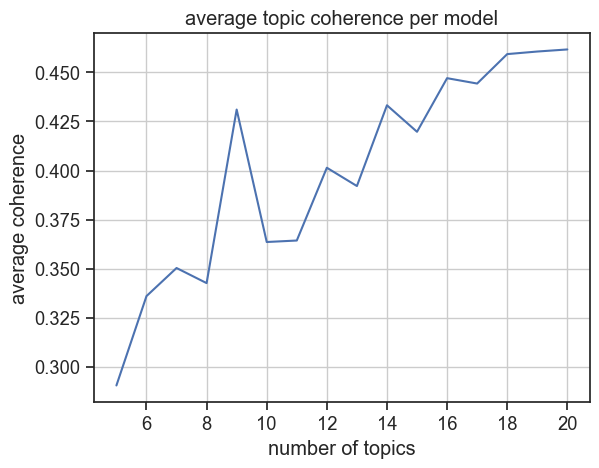

In [84]:
import matplotlib.pyplot as plt

#plotting the graph
plt.plot(x, coherence)
plt.title("average topic coherence per model")
plt.xlabel("number of topics")
plt.ylabel("average coherence")
plt.grid(True)
plt.show()

# interesting that it is different from me doing it manually before, which I think is because every time you do a topic model
# its different since its statistics. However, it is close to the 18 we manually did before
# I don't know why the coherence score never goes above 0.5, when it does a lot when manually 
# checking the coherence score, maybe a mistake in my code I could not find

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [20]:
# Let's first of all retrain a new model so we have a fresh start. 
# Let's pick 20 topics, since the average coherence
# was highest at 20 in the latest test

# again, taken from week 6 notebook

# Number of topics to return
num_topics = 20
# Numer of topic words to print out
num_topic_words = 10

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)


Topic Model Training...




In [21]:
print("\nTopic Model Results:\n\n")
#taken from week 6 notebook

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

border wall democrats security immigration must country want illegal mexico

✨Topic 1✨

news fake media people would big many never even much

✨Topic 2✨

president whitehouse live trump pm today minister prime watch join

✨Topic 3✨

trump president biden joe party republican america american donald teamtrump

✨Topic 4✨

election vote state thank fraud get new voter maga votes

✨Topic 5✨

change must climate energy people together country fossil right future

✨Topic 6✨

states united us people war must iran world country time

✨Topic 7✨

workers wage people pay social security american must family living

✨Topic 8✨

court supreme news judge justice kavanaugh cnn dr new book

✨Topic 9✨

democrats people would want left get nothing don’t even radical

✨Topic 10✨

new campaign news hillary trump fake like foxnews crooked cnn

✨Topic 11✨

great thank house north white big forward korea good carolina

✨Topic 12✨

health care people drug americans right make

In [22]:
# Q7a (code)

#finding the topic distributions, taken from week 6
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

In [16]:
from IPython.display import Markdown, display
import re
# most of this code is taken from week 6 notebook aswell

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc:
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

In [116]:
# we are getting the top docs from 3 topics, topic 3, 9 and 17
get_top_docs(original_texts, topic_distributions, topic_index=3, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=9, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=17, n=5)

### ✨Topic 3✨

trump president foxnews thank news pm watch live tonight house



---


✨  
**Topic Probability**: 0.8700322508811951  
**Document**:  These are my real words about our GREAT HEROES, not made up lies by the enemy. THANK YOU and God Bless You All! https://t.co/oFgQXzpJHU



✨  
**Topic Probability**: 0.8700322508811951  
**Document**:  RT @WhiteHouse: President @realDonaldTrump expressed America's well wishes to Prime Minister Boris Johnson for a speedy recovery. https://t.co/C3AfUuuVyv



✨  
**Topic Probability**: 0.8607825040817261  
**Document**:  RT @realDonaldTrump: Voting starts in Virginia TODAY, and we are going to WIN. You have a crazy Governor who wants to take away your guns, which he will do without me in office. He is in favor of executing babies after birth - this isn’t late-term abortion, this is a step way beyond! Vote for me...



✨  
**Topic Probability**: 0.8607825040817261  
**Document**:  RT @NASCAR: https://t.co/euuHYxPHxj



✨  
**Topic Probability**: 0.8607825040817261  
**Document**:  ....BUT MAYBE I STILL WILL. WITCH HUNT!



### ✨Topic 9✨

people us must trump american country america congress stand united



---


✨  
**Topic Probability**: 0.9118831157684326  
**Document**: Why do Americans pay the highest prices for prescription drugs in the world?

Why are there no restrictions on what a drug company can charge?

The answer is simple: other than Wall Street, the pharmaceutical industry is the most powerful political force in the **country**.



✨  
**Topic Probability**: 0.8860437870025635  
**Document**: Our job is to encourage every person in this **country** to get all of the education they can, not to punish them for getting that education. https://t.co/PtReBKXO0J



✨  
**Topic Probability**: 0.8789440989494324  
**Document**: I urge @POTUS to immediately cease the deportation raids and not deport families back to countries where a death sentence awaits.



✨  
**Topic Probability**: 0.8709010481834412  
**Document**: Drug industry launches ad campaign as it lobbies against any effort to rein in prescription costs -@joewalkerWSJ. https://t.co/YfOD1a8PeH



✨  
**Topic Probability**: 0.8665335178375244  
**Document**: "President Trump's decision to violate the [Iran nuclear] agreement was by far the most destructive act of his presidency." -@Cirincione #BernieTownHall https://t.co/RMPRfYeLfq



### ✨Topic 17✨

health care people must americans right million need street country



---


✨  
**Topic Probability**: 0.9280598759651184  
**Document**: Healthcare spending per capita:

🇺🇸 $11,702 - 92 **million** uninsured/under-insured
🇩🇪 $6,646 - 0 uninsured
🇨🇦$5,418 - 0 uninsured
🇫🇷 $5,376 - 0 uninsured
🇯🇵 $4,823 - 0 uninsured
🇬🇧 $4,653 - 0 uninsured
🇫🇮$4,578 - 0 uninsured
🇰🇷 $3,384 - 0 uninsured

Yes. #MedicareForAll saves money



✨  
**Topic Probability**: 0.9190863966941833  
**Document**: We should pay attention to this: Brazilian President Jair Bolsonaro, a far-**right** authoritarian, is rapidly destroying the Amazon rainforest. He is a threat to working **people**, minorities, journalists, and a habitable planet. No wonder Trump loves him so much.



✨  
**Topic Probability**: 0.9190863966941833  
**Document**: The United States once led the world in the percentage of young college graduates. Today, we are in 11th place, one in every four Americans has student debt, and 40 percent of all borrowers are expected to default by 2023. #CancelStudentDebt https://t.co/L1WlmUWNUj



✨  
**Topic Probability**: 0.9075552225112915  
**Document**: We **must** end U.S. support for the unauthorized, unconstitutional, and disastrous Saudi-led war in Yemen.  The suffering **people** there do not **need** more bombs.  They **need** more jobs, food and **health** **care**.



✨  
**Topic Probability**: 0.9075552225112915  
**Document**: Pompeo supports the use of torture. He has longstanding relationships with anti-Muslim extremists. And his hawkish views on Iran and North Korea could very well lead us into another disastrous war. I will vote no on his nomination.



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

# Q7b (words)

## Topic 3

The top documents of Topic 3 are all tweets by Donald Trump. Some are him retweeting his personal account, and others are in the style of Donald Trump. The topic´s key words: trump president foxnews thank news pm watch live tonight house, are already indicative of the topic being about Trump. Probably, this topic contains a lot of tweets of @REALDonaldTrump that Trump retweeted on the @POTUS account. Besides this, its Trump talking about quotes about him, or telling people to watch something like the NASCAR or FOXNEWS. Ofcourse, the topic of trump is more representative of Trump. 

## Topic 9

Topic 9, containing the words: people us must trump american country america congress stand united. From my interpretation, all top tweets are by bernie sanders. As we can see, its about different kinds of things, like wall street, education,  perspeciption costs and even two tweets where Bernie talks ABOUT Donald Trump. Most of the tweets are a sort of critique, or a 'call to action'. This is typical of the way Bernie Sanders speaks, longer sentences than Trump, on topics like protecting immigrants, educations, wall street and healthcare. The topic itself are things Bernie often talks about, which then makes sense that most top documents are by Bernie Sanders.

## Topic 17

Topic 17, containing the words: health care people must americans right million need street country. Are probably all tweets by Bernie Sanders. Again, it is about topics he talks about a lot, healthcare, debts, etc. What is interesting about these documents and the topic words, is that it probably are only sanders tweets because of the words he uses. Alot of use of the word "people", talking about the "right"-wing, his emphasis on what people "need", and what "must" me done. It is likely that sanders is overrepresented in this topic _because_ it is a topic containing words he uses often



## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [42]:
# Crete a sample of tweets

from random import sample


#100 was a bit hard to read, so I decided to do 40, 
# ofcourse, this means that the sample is less definitive
#also changed the code a bit, since the sample
# never gave a 50/50 of trump and sanders making it harder to read

#creates two variables where one is a list of the tuples 
# with tweets of donald trump and one is the tweets of sanders
trump_titles = [title for title in titles if title[0] == "@realDonaldTrump"]
sanders_titles = [title for title in titles if title[0] == "SenSanders"]

# takes 20 sample tweets from the trump list and twenty from the sanders list
target_trump_titles = sample(trump_titles, 20)
target_sanders_titles = sample(sanders_titles, 20)

# combines these to create a random but 50/50 sample
target_labels = target_trump_titles + target_sanders_titles


In [43]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()


#code taken from notebook week 6

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

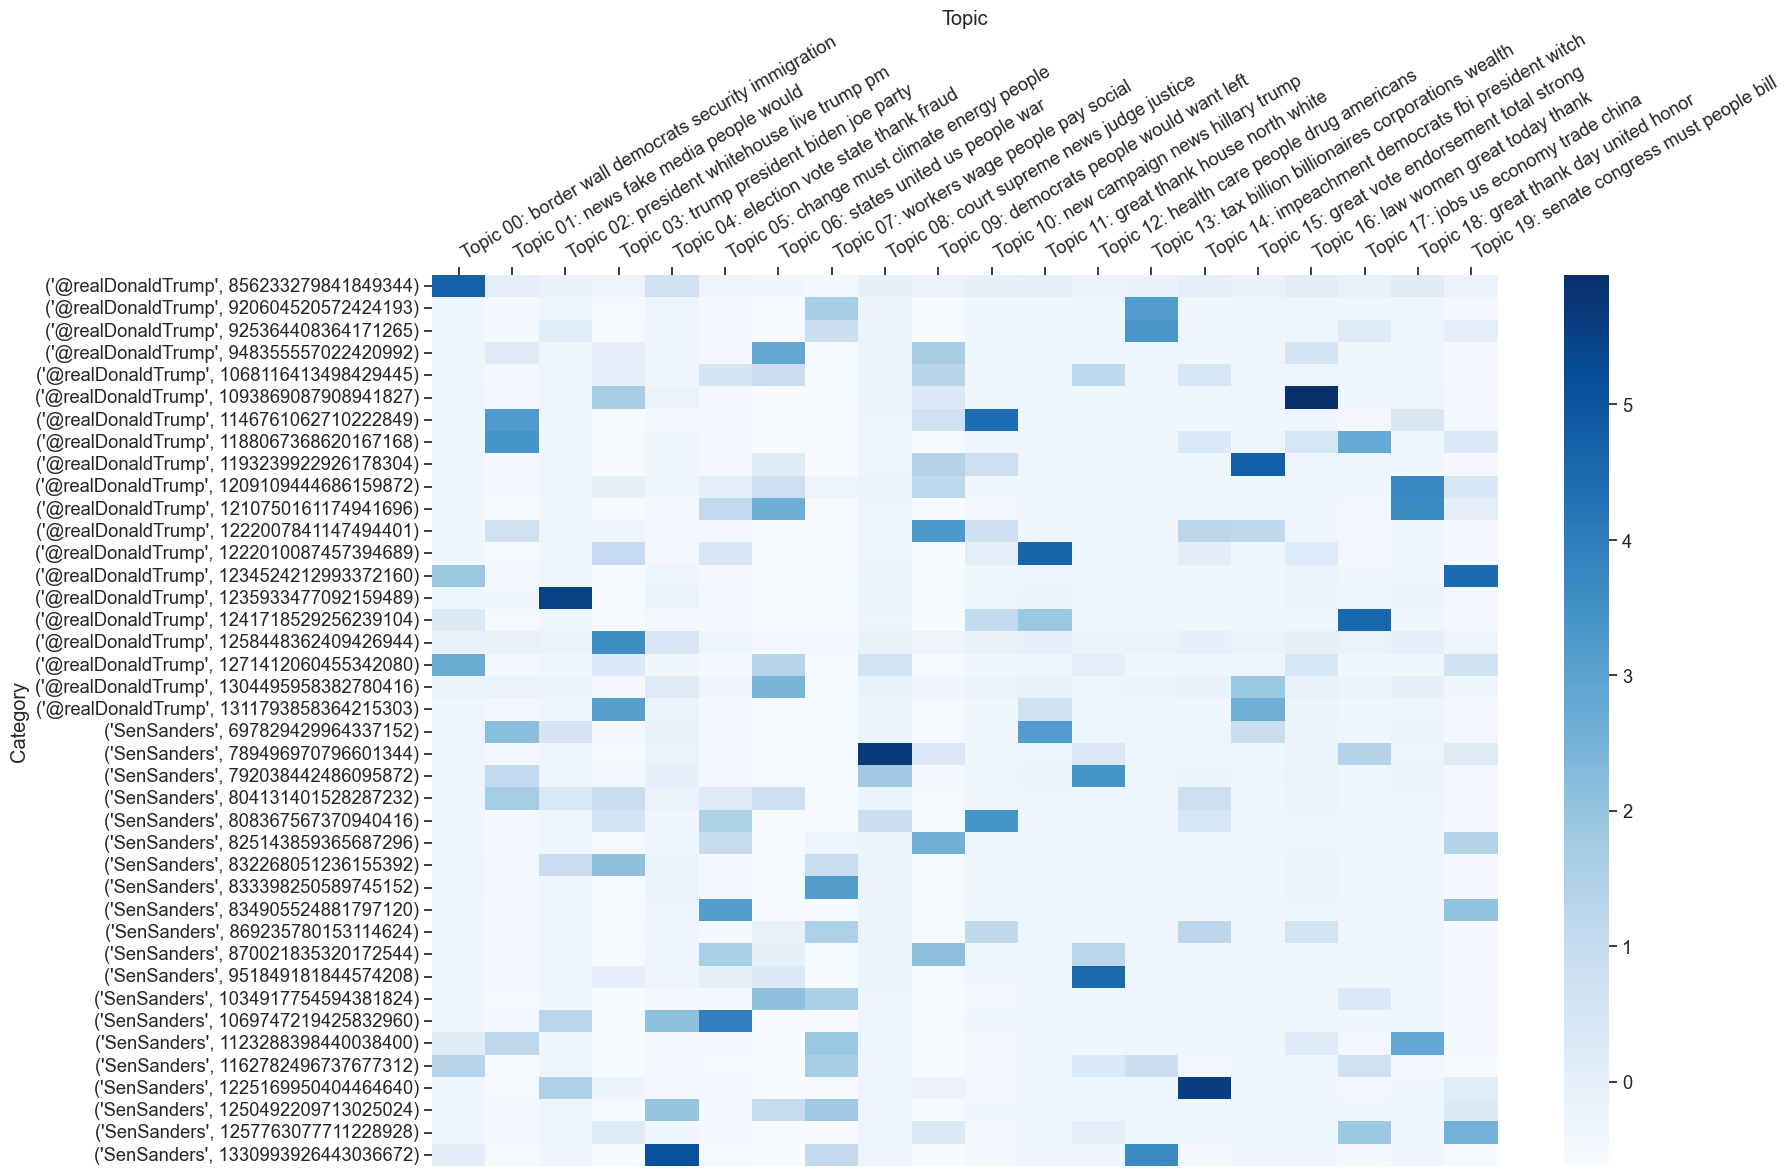

In [44]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(18,12))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

## Q9 (words)

Topics with greater Sanders representation would be more blue in the bottom half of the heatmap, and topics with greater Trump representation would be more blue in the top of the heatmap. Since not every topic is definitively more Trump or Sanders, I will just pick the ones that are pretty sure to be _in this sample_.

As you can see, in topic 8, there are 4 tweets by sanders that are close to this topic, and almost none by Trump, which you could then argue that this topic mostly represents Sanders' tweets.

Topic 16 has one big blue spot for Trump and almost none for Sanders. 

Most of the others are kinda in the middle, or really non conclusive. This could say several things. One of the things is that I made the sample size smaller than 100, which could leave out many tweets that would give more clarity to which politican the topic 'belongs'. However, I would argue that even with a 100 tweets, you could not really get anything conclusive from this heatmap. In my opinion, in this use-case a heatmap probably isn't the best way to conclude which topic belongs to which politican, since there are just so many tweets. You could for example make a average of all tweets by sanders or trump versus each topic, so you can more easily and visually compare while having a way bigger sample, maybe even the whole dataset.



### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [ ]:
# Okay so I already kind of did this, accidentally above in question Q8,
# so I will just copy the code but change 20 to 50

trump_titles = [title for title in titles if title[0] == "@realDonaldTrump"]
sanders_titles = [title for title in titles if title[0] == "SenSanders"]

target_trump_titles = sample(trump_titles, 50)
target_sanders_titles = sample(sanders_titles, 50)

target_labels = target_trump_titles + target_sanders_titles


### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [54]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)


# here i recreate df_norm_col outside of the function that was created earlier to make the heatmap


titles = titles

# Combine the labels and distributions into a list of dictionaries.
dicts_to_plot = []
for _label, _distribution in zip(titles, topic_distributions):
    if not titles or _label in titles:
        for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_individual_words[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='Category',
                                columns='Topic',
                                values='Probability')
df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

In [86]:
# here we calculate the average probabilities for each candidate 

# i really don't know if any of this is definitive, 
# but this is the only way i could come up with,
#and when manually looking at the results and the topics it kind of makes sense?

# take the mean probability per topic for all tweets of sanders and of trump by checking the titles/labels
trump_avg_probabilities = df_norm_col[[index[0] == '@realDonaldTrump' for index in df_norm_col.index]].mean()
sanders_avg_probabilities = df_norm_col[[index[0] == 'SenSanders' for index in df_norm_col.index]].mean()

# from my understanding of the dataset, if the average probability is above 0, 
# it means that topic is more _likely_ to be done by trump or sanders
# so here we filter by seeing which topics probability averages are above 0
trump_positive_avg = trump_avg_probabilities[trump_avg_probabilities > 0]
sanders_positive_avg = sanders_avg_probabilities[sanders_avg_probabilities > 0]


print("\nTopics more likely to be representative of Trump")
print(trump_positive_avg)

print("\nTopics more likely to be representative of Sanders")
print(sanders_positive_avg)




Topics more likely to be representative of Trump
Topic
Topic 00: border wall democrats security immigration    0.031819
Topic 01: news fake media people would                  0.082755
Topic 02: president whitehouse live trump pm            0.059592
Topic 03: trump president biden joe party               0.075917
Topic 04: election vote state thank fraud               0.068649
Topic 08: court supreme news judge justice              0.023407
Topic 09: democrats people would want left              0.079444
Topic 10: new campaign news hillary trump               0.091083
Topic 11: great thank house north white                 0.106070
Topic 14: impeachment democrats fbi president witch     0.104538
Topic 15: great vote endorsement total strong           0.076588
Topic 16: law women great today thank                   0.054558
Topic 17: jobs us economy trade china                   0.066300
Topic 18: great thank day united honor                  0.067182
dtype: float64

Topics more likely

In [87]:
# as you can see, the probability scores are really close to zero for the trump ones,
# meaning that there is more overlap in the Trump topics with Sanders, 
# however, they are more likely to represent Trump tweets

# Interestingly, the topics that are more likely to be representative of Sanders, 
# have higher scores than Trump's ones, making them more definitive?